Import Packages

In [1]:
!pip install webcolors

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# image processing
from PIL import Image
from io import BytesIO
import webcolors
# visualization
from importlib import reload
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Suppress image clipping warning,
Set color of plot to be contrast.
Change float format to three decimal places

In [3]:
import logging
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
sns.set(style="ticks", color_codes=True)
pd.options.display.float_format = '{:.3f}'.format

Image Exploration

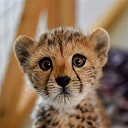

In [4]:
ori_img = Image.open("pirooz.jpg")
ori_img

In [5]:
X = np.array(ori_img.getdata())
ori_pixels = X.reshape(*ori_img.size, -1)
ori_pixels.shape

(128, 128, 3)

identify other attributes of an image, which are image size in kilobytes (KB) and the number of unique colors.

In [6]:
def imageByteSize(img):
    img_file = BytesIO()
    image = Image.fromarray(np.uint8(img))
    image.save(img_file, 'png')
    return img_file.tell()/1024

ori_img_size = imageByteSize(ori_img)
ori_img_size

31.9345703125

number of color in original picture

In [7]:
ori_img_n_colors = len(set(ori_img.getdata()))
ori_img_n_colors

12311

In [8]:
ori_img_total_variance = sum(np.linalg.norm(X - np.mean(X, axis = 0), axis = 1)**2)
ori_img_total_variance

122986548.52798036

K-Means Clustering

Here's a function to convert RGB value to its English color name

In [9]:
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
    return closest_name

we can represent each of the pixels value in a cluster by its cluster centroid. Thus, there will be only two unique pixel values in the compressed image.

In [10]:
def replaceWithCentroid(kmeans):
    new_pixels = []
    for label in kmeans.labels_:
        pixel_as_centroid = list(kmeans.cluster_centers_[label])
        new_pixels.append(pixel_as_centroid)
    new_pixels = np.array(new_pixels).reshape(*ori_img.size, -1)
    return new_pixels

Our clustering step is done, let's take a look at the compressed image result.

1. Within Cluster Sum of Square ($WCSS$), measures the sum of squared Euclidean distance of all the points within a cluster to its cluster centroid.

    $WCSS = \sum\limits_{i=0}^N ||x_i-c_{p(i)}||^2$
    
    where:
    * $N$ is the number of data points
    * $x_i$ is the $i$-th data, a 3D vector of RGB value
    * $c_{p(i)}$ is the cluster centroid of data-$i$

2. Between Cluster Sum of Square ($BCSS$), measures the sum of squared Euclidean distance between all centroids.

    $BCSS = \sum\limits_{j=0}^k n_j . ||c_j-\bar{x}||^2$
    
    where:
    * $k$ is the number of cluster
    * $n_j$ is the total data present in cluster-$j$
    * $c_j$ is the centroid of cluster-$j$, a 3D vector of RGB value
    * $\bar{x}$ is the mean of each RGB value

3. Explained Variance, measures how many percents that the compressed image can explain the variance of the original image.

    $Explained Variance = \dfrac{BCSS}{WCSS+BCSS}$
    
If each pixel is considered as an individual cluster ($k = N$), then $WCSS$ is equal to $0$.

Hence, $Explained Variance = 100\%$

4. Image size, measured in kilobytes to evaluate the reduction/compression performance.


In [11]:
def calculateBCSS(X, kmeans):
    _, label_counts = np.unique(kmeans.labels_, return_counts = True)
    diff_cluster_sq = np.linalg.norm(kmeans.cluster_centers_ - np.mean(X, axis = 0), axis = 1)**2
    return sum(label_counts * diff_cluster_sq)

run kmeans and plot for i=2:16

In [12]:
range_k_clusters = (2, 17)

kmeans_result = []
for k in range(*range_k_clusters):
    # CLUSTERING
    kmeans = KMeans(n_clusters = k,random_state = 123).fit(X)
    
    # REPLACE PIXELS WITH ITS CENTROID
    new_pixels = replaceWithCentroid(kmeans)
    
    # EVALUATE
    WCSS = kmeans.inertia_
    BCSS = calculateBCSS(X, kmeans)
    exp_var = 100*BCSS/(WCSS + BCSS)
    
    metric = {
        "No. of Colors": k,
        "Centroids": list(map(get_colour_name, np.uint8(kmeans.cluster_centers_))),
        "Pixels": new_pixels,
        "WCSS": WCSS,
        "BCSS": BCSS,
        "Explained Variance": exp_var,
        "Image Size (KB)": imageByteSize(new_pixels)
    }
    
    kmeans_result.append(metric)
kmeans_result = pd.DataFrame(kmeans_result).set_index("No. of Colors")

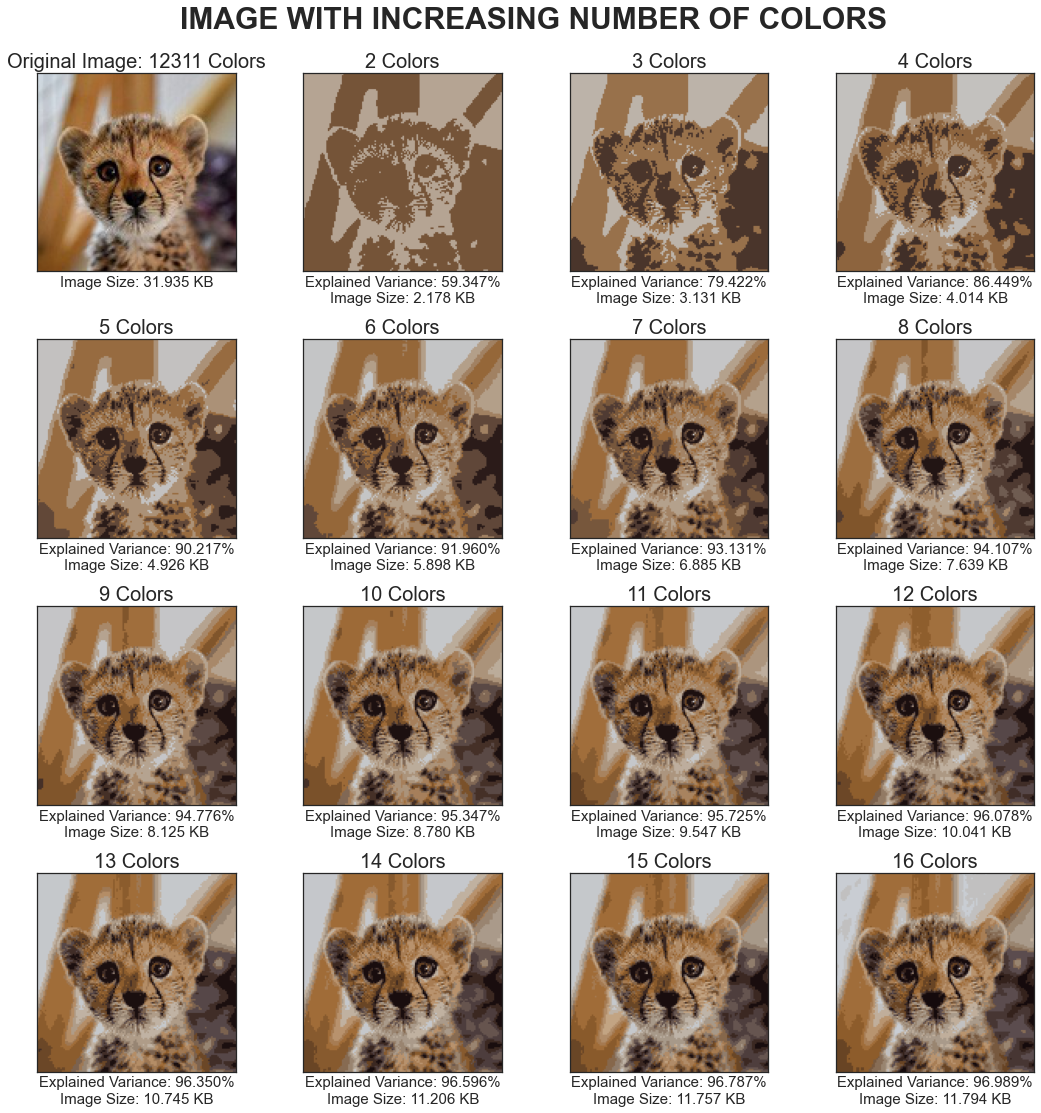

In [13]:
fig, axes = plt.subplots(4, 4, figsize=(15,15))

# PLOT ORIGINAL IMAGE
axes[0][0].imshow(X.reshape(*ori_img.size, 3))
axes[0][0].set_title("Original Image: {} Colors".format(ori_img_n_colors), fontsize = 20)
axes[0][0].set_xlabel("Image Size: {:.3f} KB".format(ori_img_size), fontsize = 15)
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])

# PLOT COLOR-REDUCED IMAGE
for ax, k, pixels in zip(axes.flat[1:], kmeans_result.index, kmeans_result["Pixels"]):
    compressed_image = np.array(pixels/255).reshape(*ori_img.size, 3)
    ax.imshow(compressed_image)
    ax.set_title("{} Colors".format(k), fontsize=20)
    ax.set_xlabel("Explained Variance: {:.3f}%\nImage Size: {:.3f} KB".format(kmeans_result.loc[k, "Explained Variance"],
                                                                              kmeans_result.loc[k, "Image Size (KB)"]),
                  fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.suptitle("IMAGE WITH INCREASING NUMBER OF COLORS", size = 30, y = 1.03, fontweight = "bold")
plt.show()